written by Hazwan Adhikara

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string

from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Dense, Dropout, 
                                     GlobalAveragePooling1D, Conv1D, 
                                     GlobalMaxPooling1D, SimpleRNN, 
                                     LSTM, GRU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, f1_score, confusion_matrix


## Data Preparation

In [2]:
train = pd.read_csv('./data/train.csv', encoding='latin-1')
test = pd.read_csv('./data/test.csv', encoding='latin-1')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

display(train.head())
display(test.head())

Train shape: (27481, 10)
Test shape: (3532, 8)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


,textID,text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Kmï¿½),Density (P/Kmï¿½)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,morning,0-20,Afghanistan,38928346,652860.0,60
1,96d74cb729,Shanghai is also really exciting (precisely -...,noon,21-30,Albania,2877797,27400.0,105
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",night,31-45,Algeria,43851044,2381740.0,18
3,01082688c6,happy bday!,morning,46-60,Andorra,77265,470.0,164
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
train.info()

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


,Population -2020,Land Area (Km²),Density (P/Km²)
count,2.748100e+04,2.748100e+04,27481.000000
mean,4.018497e+07,6.621730e+05,357.686583
std,1.504946e+08,1.807425e+06,2013.750702
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [4]:
train.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [5]:
bad_idx = train[train['text'].isna() & train['selected_text'].isna()].index
print("Missing Value Rows:", bad_idx.tolist())

train = train.dropna(subset=['text', 'selected_text']).reset_index(drop=True)

Missing Value Rows: [314]


In [6]:
train.isna().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [7]:
print("Train shape:", train.shape)

Train shape: (27480, 10)


## Exploratory Data Analysis

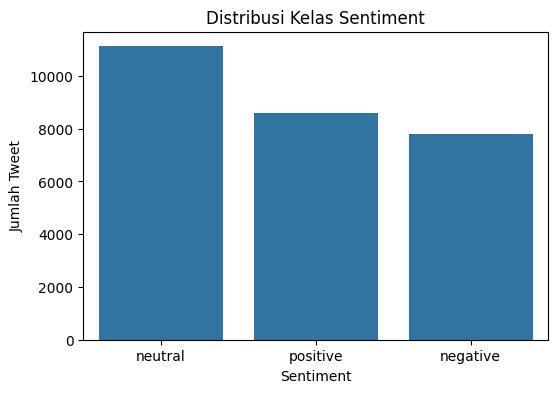

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='sentiment', order=train['sentiment'].value_counts().index)
plt.title('Distribusi Kelas Sentiment')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Sentiment')
plt.show()


           char_len      word_len
count  27480.000000  27480.000000
mean      68.354949     12.902875
std       35.624417      6.925938
min        3.000000      1.000000
25%       39.000000      7.000000
50%       64.000000     12.000000
75%       97.000000     18.000000
max      159.000000     33.000000


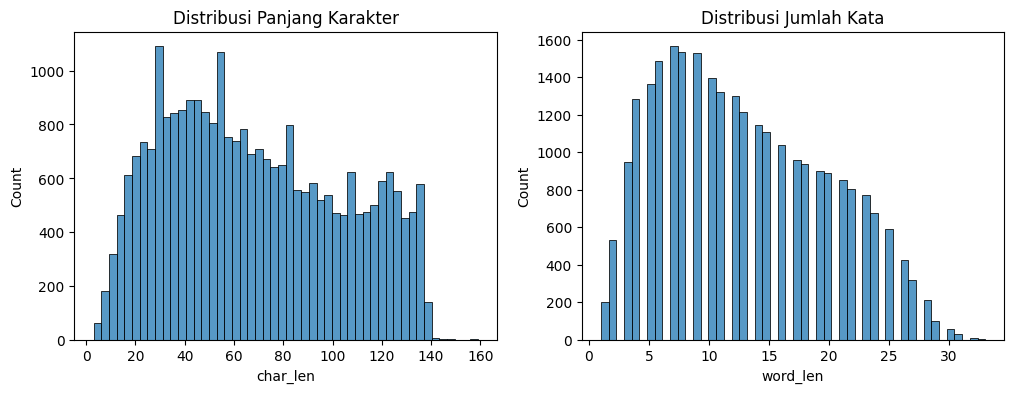

In [9]:
# Hitung jumlah kata & karakter
train['char_len'] = train['text'].str.len()
train['word_len'] = train['text'].str.split().str.len()

# Statistik panjang
print(train[['char_len','word_len']].describe())

# Visualisasi
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(train['char_len'], bins=50, ax=axes[0])
axes[0].set_title('Distribusi Panjang Karakter')
sns.histplot(train['word_len'], bins=50, ax=axes[1])
axes[1].set_title('Distribusi Jumlah Kata')
plt.show()



Top 20 kata untuk sentiment neutral:
[('i', 6207), ('to', 4152), ('the', 3554), ('a', 2552), ('it', 2026), ('my', 2016), ('you', 1958), ('and', 1876), ('in', 1606), ('is', 1515), ('for', 1439), ('s', 1288), ('on', 1283), ('of', 1251), ('t', 1241), ('but', 1145), ('me', 1129), ('that', 1061), ('have', 1012), ('just', 923)]

Top 20 kata untuk sentiment negative:
[('i', 5792), ('to', 2900), ('the', 2463), ('my', 2043), ('a', 1825), ('it', 1642), ('and', 1595), ('is', 1349), ('t', 1274), ('in', 1134), ('you', 1053), ('that', 1022), ('me', 1003), ('so', 985), ('s', 954), ('m', 918), ('of', 908), ('for', 881), ('not', 822), ('on', 802)]

Top 20 kata untuk sentiment positive:
[('i', 4669), ('the', 3015), ('to', 2980), ('a', 2417), ('you', 2338), ('it', 1738), ('and', 1694), ('my', 1488), ('s', 1395), ('for', 1337), ('day', 1259), ('is', 1145), ('in', 1076), ('good', 1066), ('of', 996), ('that', 931), ('love', 889), ('happy', 858), ('so', 834), ('have', 831)]


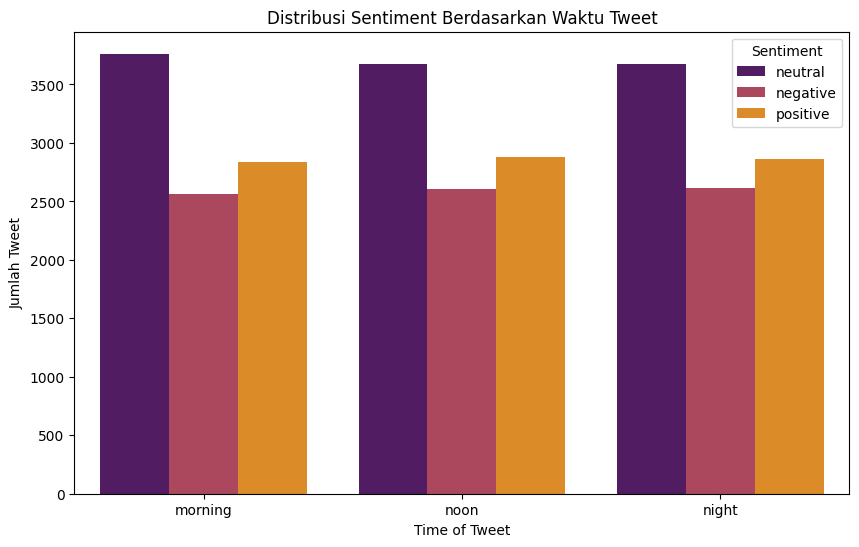

In [10]:
def get_top_n(words, n=20):
    all_words = ' '.join(words).lower()
    tokens = re.findall(r'\b\w+\b', all_words)
    counter = Counter(tokens)
    return counter.most_common(n)

for sentiment in train['sentiment'].unique():
    texts = train.loc[train['sentiment']==sentiment, 'text']
    top20 = get_top_n(texts, 20)
    print(f"\nTop 20 kata untuk sentiment {sentiment}:")
    print(top20)

# Analisis hubungan antara waktu tweet dan sentiment
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='Time of Tweet', hue='sentiment', palette="inferno")
plt.title('Distribusi Sentiment Berdasarkan Waktu Tweet')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Time of Tweet')
plt.legend(title='Sentiment')
plt.show()

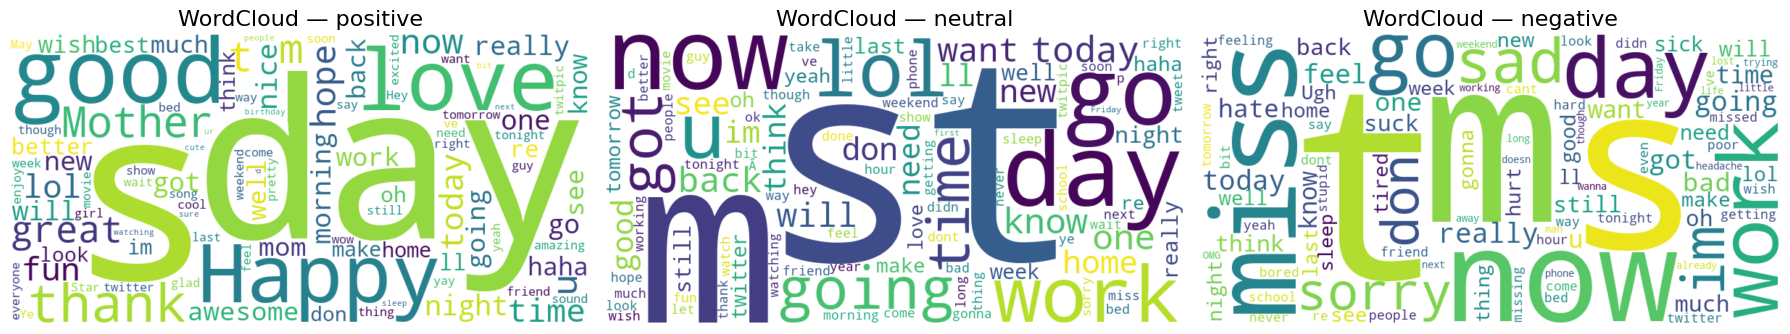

In [11]:
pos_text = ' '.join(train[train['sentiment']=='positive']['text'].dropna().tolist())
neu_text = ' '.join(train[train['sentiment']=='neutral']['text'].dropna().tolist())
neg_text = ' '.join(train[train['sentiment']=='negative']['text'].dropna().tolist())

texts = {
    'positive': pos_text,
    'neutral':  neu_text,
    'negative': neg_text
}

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for ax, (sentiment, txt) in zip(axes, texts.items()):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        collocations=False
    ).generate(txt)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'WordCloud — {sentiment}', fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()


  Age of User  Age_of_User_Code
0        0-20                 1
1       21-30                 2
2       31-45                 3
3       46-60                 4
4       60-70                 5
5      70-100                 6


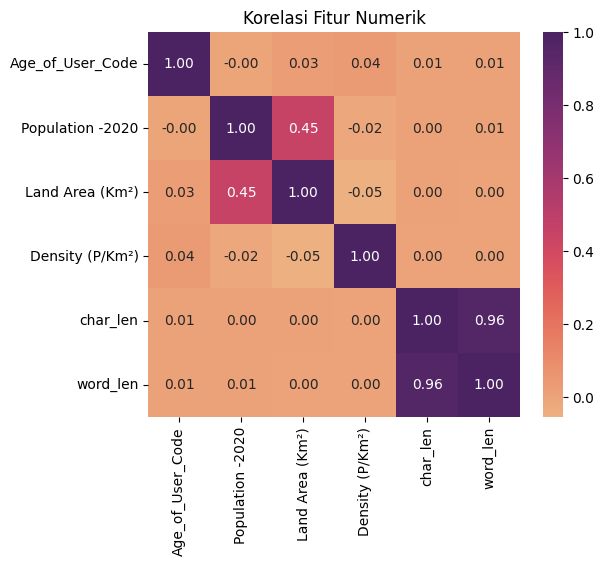

In [12]:
age_mapping = {
    '0-20':  1,
    '21-30': 2,
    '31-45': 3,
    '46-60': 4,
    '60-70': 5,
    '70-100': 6
}

train['Age_of_User_Code'] = train['Age of User'].map(age_mapping)

print(train[['Age of User', 'Age_of_User_Code']].drop_duplicates())

num_cols = [
    'Age_of_User_Code',
    'Population -2020',
    'Land Area (Km²)',
    'Density (P/Km²)',
    'char_len',
    'word_len'
]
corr = train[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='flare')
plt.title('Korelasi Fitur Numerik')
plt.show()


## Data Pre-processing

In [13]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hazwanadh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hazwanadh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))

def preprocess_english(text):
    # Case folding (mengkonversi teks ke dalam format huruf kecil
    text = text.lower()
    
    # Hilangin URL, mentions, hashtags, angka
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Menghapus tanda baca dan semua karakter yang bukan huruf (a-z) atau spasi 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Tokenization 
    tokens = nltk.word_tokenize(text)
    
    # Stemming & stopword removal
    processed = [
        stemmer.stem(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    return processed

samples = [
    "_i_am_jes YAY! congrats! i`m afraid to check my grades!",
    "Sooo SAD I will miss you here in San Diego!!!",
    "as much as i love to be hopeful",
    "Then you should check out http://twittersucks.com and connect with other tweeple who hate twitter"
]

for s in samples:
    print(s, "=>", preprocess_english(s))

# Terapkan ke seluruh dataset
train['tokens'] = train['text'].fillna('').apply(preprocess_english)
test ['tokens'] = test ['text'].fillna('').apply(preprocess_english)

_i_am_jes YAY! congrats! i`m afraid to check my grades! => ['iamj', 'yay', 'congrat', 'im', 'afraid', 'check', 'grade']
Sooo SAD I will miss you here in San Diego!!! => ['sooo', 'sad', 'miss', 'san', 'diego']
as much as i love to be hopeful => ['much', 'love', 'hope']
Then you should check out http://twittersucks.com and connect with other tweeple who hate twitter => ['check', 'connect', 'tweepl', 'hate', 'twitter']


In [15]:
train['clean_text'] = train['tokens'].apply(lambda toks: ' '.join(toks))
test ['clean_text'] = test ['tokens'].apply(lambda toks: ' '.join(toks))

train[['text','tokens', 'clean_text']].head()

,text,tokens,clean_text
0,"I`d have responded, if I were going","[id, respond, go]",id respond go
1,Sooo SAD I will miss you here in San Diego!!!,"[sooo, sad, miss, san, diego]",sooo sad miss san diego
2,my boss is bullying me...,"[boss, bulli]",boss bulli
3,what interview! leave me alone,"[interview, leav, alon]",interview leav alon
4,"Sons of ****, why couldn`t they put them on t...","[son, couldnt, put, releas, alreadi, bought]",son couldnt put releas alreadi bought


In [16]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

X = tokenizer.texts_to_sequences(train['clean_text'])
X = pad_sequences(X, maxlen=100, padding='post', truncating='post')

# Label encoding
le = LabelEncoder()
y = le.fit_transform(train['sentiment'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Modelling

In [17]:
# Early Stopping & Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
def build_fnn(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

def build_rnn(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        SimpleRNN(128, return_sequences=False),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

def build_lstm(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(3, activation='softmax')
    ])
    return model

def build_gru(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        GRU(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(3, activation='softmax')
    ])
    return model

def build_cnn(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1790182004.py, line 2)

In [ ]:
fnn_model = build_fnn(vocab_size=10000, embedding_dim=100, input_length=50)
fnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_fnn = fnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

In [ ]:
rnn_model = build_rnn(vocab_size=10000, embedding_dim=100, input_length=50)
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_rnn = rnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

In [ ]:
lstm_model = build_lstm(vocab_size=10000, embedding_dim=100, input_length=50)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_lstm = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

In [ ]:
gru_model = build_gru(vocab_size=10000, embedding_dim=100, input_length=50)
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_gru = gru_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

In [ ]:
cnn_model = build_cnn(vocab_size=10000, embedding_dim=100, input_length=50)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

## Evaluation & F1 Score

In [ ]:
def plot_history(histories, model_names):
    plt.figure(figsize=(18, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_history(
    [history_lstm, history_rnn, history_gru, history_cnn, history_fnn],
    ['LSTM', 'RNN', 'GRU', 'CNN', 'FNN']
)

In [ ]:
def evaluate_model(model, X_val, y_test, name):
    y_pred = model.predict(X_val)
    y_pred_labels = y_pred.argmax(axis=1)

    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print(f'\n📌 {name} - F1 Score: {f1:.4f}\n')
    print(classification_report(y_test, y_pred_labels, target_names=['Negative', 'Neutral', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
evaluate_model(lstm_model, X_val, y_val, 'LSTM')
evaluate_model(rnn_model, X_val, y_val, 'RNN')
evaluate_model(gru_model, X_val, y_val, 'GRU')
evaluate_model(cnn_model, X_val, y_val, 'CNN')
evaluate_model(fnn_model, X_val, y_val, 'FNN')

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1) Setup dan fit pada train
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

# 2) Ubah ke sequence
X_train = tokenizer.texts_to_sequences(train['clean_text'])
X_test  = tokenizer.texts_to_sequences(test['clean_text'])

# 3) Padding agar panjang sama dengan yang dipakai di train
max_len = 100  # atau sesuai nilai yang kamu pakai waktu pad_sequences(train)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(X_test,  maxlen=max_len, padding='post', truncating='post')


In [ ]:
best_model = fnn_model  # JANGAN LUPA GANTI

probs = best_model.predict(X_test)      

pred_idx = probs.argmax(axis=1)

pred_labels = le.inverse_transform(pred_idx)

submission = pd.DataFrame({
    'textID':      test['textID'],
    'sentiment':   pred_labels
})

submission.to_csv('submission4.csv', index=False)
print("File submission.csv berhasil dibuat!")
